### LinkedIn Learning Course:
# Python: Working with Predictive Analytics
https://www.linkedin.com/learning/python-working-with-predictive-analytics/predict-data-in-python

**Course Author:** Isil Berkun

This notebook is the course content put into my own words/code.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    MinMaxScaler, 
    StandardScaler, 
    OneHotEncoder, 
    LabelEncoder, 
    PolynomialFeatures
)

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

### Convenience functions

In [24]:
from IPython.display import display

def eg(obj, msg=None):
    """Convenience function for displaying output."""
    print()
    if msg:
        print(msg)
    else:
        print("E.g.")
    display(obj)

def split_and_scale(X, y, random_state=None):
    """Convenience function used to split the data into test and train sets, and to scale the independent variables."""
    if random_state:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    # standardize features: take away the mean, and scale to unit variance
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train.astype(np.float))
    X_test= sc.transform(X_test.astype(np.float))

    return X_train, X_test, y_train, y_test

## Setup and data preparation

In [25]:
# import data
data = pd.read_csv("Exercise Files/Datasets/insurance.csv")

In [26]:
# return a Series object that shows how many null values (e.g. NaN's) each column has. 
count_nan = data.isnull().sum()
count_nan

age         0
sex         0
bmi         5
children    0
smoker      0
region      0
charges     0
dtype: int64

In [27]:
count_nan[count_nan > 0]

bmi    5
dtype: int64

### IMPUTATION:
Here we fill the NaN values with the column mean

In [28]:
# fill the nan values with the column mean
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
count_nan = data.isnull().sum()

print("Now there are no NaN values remaining:")
count_nan[count_nan > 0]

Now there are no NaN values remaining:


Series([], dtype: int64)

In [29]:
eg(
    data.iloc[:, [1,4]], 
    "An example of categorical variables:"
)


An example of categorical variables:


,sex,smoker
0,female,yes
1,male,no
2,male,no
3,male,no
4,male,no
...,...,...
1333,male,no
1334,female,no
1335,female,no
1336,female,no


In [30]:
# turn the above two columns into ndarrays so that we can pass them to sklearn for label encoding.
sex = data.iloc[:, 1:2].values
smoker = data.iloc[:, 4:5].values
print(sex)

[['female']
 ['male']
 ['male']
 ...
 ['female']
 ['female']
 ['female']]


In [31]:
print(sex[:,0])

['female' 'male' 'male' ... 'female' 'female' 'female']


### Encoding the categorical data into numerical
This is necessary, as the computer can only work with numerical data.

In [32]:
sex = data.iloc[:, 1:2].values

# class used to encode categorical features into numerical
le = LabelEncoder()

eg(
    le.fit_transform(sex[:,0]),
    "An example of how the categorical variable has been "
    "turned into a numerical one:"
)


An example of how the categorical variable has been turned into a numerical one:


array([0, 1, 1, ..., 0, 0, 0])

In [33]:
# the reason for the funny indexing is that it turns the array into
# a 1D array, and then assigns it to an object of the same shape
sex[:,0] = le.fit_transform(sex[:,0])

In [34]:
eg(
    sex[:,0],
    "The 1D array:"
)
eg(
    sex,
    "Original array:"
)


The 1D array:


array([0, 1, 1, ..., 0, 0, 0], dtype=object)


Original array:


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [35]:
sex = pd.DataFrame(sex)
sex.columns = ['sex']
sex

,sex
0,0
1,1
2,1
3,1
4,1
...,...
1333,1
1334,0
1335,0
1336,0


In [36]:
# related to the above...
le_sex_mapping = dict(list(zip(le.classes_, le.transform(le.classes_))))
eg(le_sex_mapping, "sex mapping:")


sex mapping:


{'female': 0, 'male': 1}

In [37]:
# let's do the same as what we did for the sex column but now for the 'smoker' column

smoker = data.iloc[:, 4:5].values

le = LabelEncoder()
smoker[:,0] = le.fit_transform(smoker[:,0])
smoker = pd.DataFrame(smoker, columns=['smoker'])
le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

eg(smoker, "smoker column turned into binary variable:")
eg(le_smoker_mapping, "smoker mapping:")


smoker column turned into binary variable:


,smoker
0,1
1,0
2,0
3,0
4,0
...,...
1333,0
1334,0
1335,0
1336,0



smoker mapping:


{'no': 0, 'yes': 1}

### One-hot encoding
The 'region' column of the dataset has more than two categories. Therefore we cannot simply use a binary variable. We will need to use one-hot encoding. This is where we output multiple binary columns, one for each category. E.g. a 1 in the "southeast" column and a 0 in the other three will then mean that "southeast" is the selected category for the observation.

In [38]:
print(data['region'].unique())

['southwest' 'southeast' 'northwest' 'northeast']


In [39]:
# note that "[:, np.newaxis]" applied on the numpy array turns the 
# 1D array into a 2D array, which is required for the OneHotEncoder class.

region_values = data['region'].values[:, np.newaxis]
region_values

array([['southwest'],
       ['southeast'],
       ['southeast'],
       ...,
       ['southeast'],
       ['southwest'],
       ['northwest']], dtype=object)

In [40]:
region_values = data.iloc[:,5:6].values

# one-hot encoded array. One column for each category. (may need to convert to int. It may be
# returning floats because there are NaN values somewhere...)
ohe = OneHotEncoder()
region_encoded = ohe.fit_transform(region_values).toarray()
region_encoded

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [42]:
eg(
    ohe.categories_,
    "Note that for some reason it comes surrounded by a Python list:"
)


Note that for some reason it comes surrounded by a Python list:


[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [43]:
region = pd.DataFrame(region_encoded, columns=ohe.categories_[0])
eg(
    region,
    """Note they're float values. This is probably because there
was a NaN value found somewhere (? didn't we get rid of these?).
"The int type can't handle NaN values, so it's converted to float.
Look into converting to pd.Int64Dtype()."""
)


Note they're float values. This is probably because there
was a NaN value found somewhere (? didn't we get rid of these?).
"The int type can't handle NaN values, so it's converted to float.
Look into converting to pd.Int64Dtype().


,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1333,0.0,1.0,0.0,0.0
1334,1.0,0.0,0.0,0.0
1335,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,1.0


### PUTTING THINGS TOGETHER
Put all cleaned features back into one dataframe. Here we also split into training and test sets.

In [44]:
X_numerical = data[['age','bmi','children']].copy()
X_final = pd.concat([X_numerical, region, sex, smoker], axis=1)
y_final = data[['charges']].copy()

# splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0)
X_train

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
1271,25,34.485,0,0.0,1.0,0.0,0.0,0,0
1313,19,34.700,2,0.0,0.0,0.0,1.0,0,1
2,28,33.000,3,0.0,0.0,1.0,0.0,1,0
405,52,38.380,2,1.0,0.0,0.0,0.0,0,0
482,18,31.350,0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
763,27,26.030,0,1.0,0.0,0.0,0.0,1,0
835,42,35.970,2,0.0,0.0,1.0,0.0,1,0
1216,40,25.080,0,0.0,0.0,1.0,0.0,1,0
559,19,35.530,0,0.0,1.0,0.0,0.0,1,0


### Standardizing features
Take away the mean, and scale to unit variance. This is important for some machine learning algorithms to stop variables with larger values taking more precendent in the model training.

In [45]:
# FEATURE SCALING

# normalizing
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train.astype(np.float))
# X_test= scaler.transform(X_test.astype(np.float))

# standardizing
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

eg(X_train)


E.g.


array([[-1.03606235,  0.61468414, -0.91008919, ..., -0.58766091,
        -0.98669564, -0.4996512 ],
       [-1.46484381,  0.64957783,  0.7540739 , ...,  1.70166159,
        -0.98669564,  2.00139616],
       [-0.82167162,  0.37367425,  1.58615545, ..., -0.58766091,
         1.01348375, -0.4996512 ],
       ...,
       [ 0.03589131, -0.91171181, -0.91008919, ..., -0.58766091,
         1.01348375, -0.4996512 ],
       [-1.46484381,  0.78428369, -0.91008919, ..., -0.58766091,
         1.01348375, -0.4996512 ],
       [-0.46435373, -1.97962095, -0.07800765, ...,  1.70166159,
        -0.98669564, -0.4996512 ]])

## Maching learning models
### Simple Linear Regression

In [60]:
lr = LinearRegression()

# train first
lr.fit(X_train, y_train)

# ... then predict--on both the training AND the test set
y_train_prediction = lr.predict(X_train)
y_test_prediction = lr.predict(X_test)

### Example plot
It is hard to plot this model because it is high dimension. However, for example purposes, I'll plot the age variable (column 0 from the design matrix) vs. the 'charges' variable which we are trying to predict. In other words, we're now looking at a 1 dimensional abstraction from the entire model. 

Note that the age variable (on the x-axis) has been standardized.

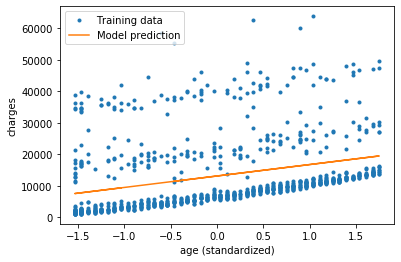

In [114]:
# training data
plt.plot(X_train[:,0], y_train, '.', label="Training data")

# training features. Note that it doesn't matter whether we use
# training or test data here; as they would both just be input 
# as the independent variables into the linear model below.
_x = X_train[:,0].copy()

# basic 1 dimensional linear model (i.e. y = mx + c) 
_prediction = _x * lr.coef_.ravel()[0] + lr.intercept_

plt.plot(X_train[:,0], _prediction, label="Model prediction")
plt.legend(loc="upper left")
plt.ylabel("charges")
plt.xlabel("age (standardized)");

Back into the full dimensional system...

In [115]:
# print out the gradient and intercept of the line

print(f"Gradient: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")

print(
    "Training set score: %.3f; Test set score: %.3f" % (
        lr.score(X_train, y_train),
        lr.score(X_test, y_test)
))

Gradient: [[3624.36356197 1966.90473927  661.35603447  242.57758422  -29.49212715
  -104.19142495  -99.14488063  -44.54996175 9310.54961689]]
Intercept: [13141.35083164]
Training set score: 0.728; Test set score: 0.786


### POLYNOMIAL REGESSION
Note that polynomial regression is still a subset of linear regression.

In [116]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_final)

# could you put this line before making the X_poly matrix?
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_final, test_size=0.33, random_state=0)
print("Notice the huge change in number of columns:\n")
print("X_train_poly shape: \t%s" % str(X_train_poly.shape))
print("X_test_poly shape: \t%s" % str(X_test_poly.shape))
print()
print("X_train shape: \t%s" % str(X_train.shape))
print("X_test shape: \t%s" % str(X_test.shape))

Notice the huge change in number of columns:

X_train_poly shape: 	(896, 220)
X_test_poly shape: 	(442, 220)

X_train shape: 	(896, 9)
X_test shape: 	(442, 9)


In [117]:
# standardizing

#standard scaler (fit transform on train, fit only on test)
sc = StandardScaler()
X_train_final_poly = sc.fit_transform(X_train_poly.astype(np.float))
X_test_final_poly = sc.transform(X_test_poly.astype(np.float))

# (why do we not apply normalization?)

In [118]:
poly_lr = LinearRegression()
poly_lr.fit(X_train_final_poly, y_train_poly)

# use these to make plots ...
y_train_pred = poly_lr.predict(X_train_final_poly)
y_test_pred = poly_lr.predict(X_test_poly)

In [119]:
print(poly_lr.coef_)
print()
print(poly_lr.intercept_)

[[ 1.38221886e-13 -2.00328934e+15  1.94967630e+15 -1.88619598e+15
   7.07981961e+15  3.12607250e+15  2.90905638e+15  1.83393980e+15
   3.89287551e+14 -4.66675630e+14  3.65619477e+14  1.05561285e+15
   1.95500892e+14  1.75236367e+15  1.58085400e+15  5.68046159e+14
   1.52617237e+15 -3.56727204e+14  2.38854263e+14 -5.64426982e+14
  -8.40929241e+14 -2.00239750e+15 -1.95580622e+15 -2.29953448e+15
  -2.39355706e+15  8.35623848e+13  1.26311680e+15  8.22272302e+13
   3.11846624e+14  6.95081692e+14  5.85271490e+14  3.97941758e+14
  -3.16334526e+14  3.92408934e+13 -7.69676750e+14  6.39476356e+13
   1.41129610e+14 -1.78262473e+13  2.97137013e+14  6.61499215e+14
   1.17501592e+15  1.09298561e+13  2.68296687e+13  6.82024709e+13
   1.60635641e+14  1.44030776e+15  2.54221835e+13  3.15431509e+14
  -6.83204359e+13  1.96335805e+15  1.40117735e+14  9.16214707e+13
  -4.28731122e+14  5.84465169e+13 -3.24881093e+14 -1.89500000e+03
   2.93025000e+03  4.61275000e+03 -3.02943233e+14 -3.10050034e+14
  -3.14776

In [120]:
print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854


### SUPPORT VECTOR REGRESSION

In [121]:
X_train_SVR, X_test_SVR, y_train_SVR, y_test_SVR = train_test_split(X_final, y_final, test_size=0.33,
                                                                    random_state=0)

# SVR can be affected by outliers, so it's extra important to apply scaling. 
# Remember that the reason we want to scale is because we want to avoid features
# with larger values to dominate the model result.
sc = StandardScaler()
X_train_SVR = sc.fit_transform(X_train_SVR.astype(np.float))
X_test_SVR = sc.fit_transform(X_test_SVR.astype(np.float))


In [122]:
svr = SVR(kernel="linear", C=300)
svr.fit(X_train_SVR, y_train_SVR.values[:,0])

SVR(C=300, kernel='linear')

In [123]:
y_train_pred = svr.predict(X_train_SVR)
y_test_pred = svr.predict(X_test_SVR)

In [124]:
print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))
print("SVR train score: \t\t%.3f; \tSVR test score: \t\t%.3f" % (
    svr.score(X_train_SVR, y_train_SVR),
    svr.score(X_test_SVR, y_test_SVR)
))
print("\nNote: the SVR test score comes out slightly differently to the instructor's example..."
      "\nTheirs comes out as 0.628.")

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854
SVR train score: 		0.598; 	SVR test score: 		0.619

Note: the SVR test score comes out slightly differently to the instructor's example...
Theirs comes out as 0.628.


### DECISION TREE REGRESSION

In [125]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = split_and_scale(X_final, y_final, random_state=0)

dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train_dt, y_train_dt.values[:,0])

y_train_pred = dt.predict(X_train_dt)
y_test_pred = dt.predict(X_test_dt)

print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))
print("SVR train score: \t\t%.3f; \tSVR test score: \t\t%.3f" % (
    svr.score(X_train_SVR, y_train_SVR),
    svr.score(X_test_SVR, y_test_SVR)
))
print("DTR train score: \t\t%.3f; \tDTR test score: \t\t%.3f" % (
    dt.score(X_train_dt, y_train_dt),
    dt.score(X_test_dt, y_test_dt)
))
print(
    "\nNotice the test score is worse than the training score. This shows the model is overfit."
    "\nThis is the tendency for tree regressors."
)

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854
SVR train score: 		0.598; 	SVR test score: 		0.619
DTR train score: 		1.000; 	DTR test score: 		0.697

Notice the test score is worse than the training score. This shows the model is overfit.
This is the tendency for tree regressors.


### RANDOM FOREST REGRESSION

In [126]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = split_and_scale(X_final, y_final, random_state=0)

forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(X_train_rf, y_train_rf.values[:,0])
y_train_pred = forest.predict(X_train_rf)
y_test_pred = forest.predict(X_test_rf)

print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))
print("SVR train score: \t\t%.3f; \tSVR test score: \t\t%.3f" % (
    svr.score(X_train_SVR, y_train_SVR),
    svr.score(X_test_SVR, y_test_SVR)
))
print("DTR train score: \t\t%.3f; \tDTR test score: \t\t%.3f" % (
    dt.score(X_train_dt, y_train_dt),
    dt.score(X_test_dt, y_test_dt)
))
print("RF train score: \t\t%.3f; \tRF test score: \t\t\t%.3f" % (
    forest.score(X_train_rf, y_train_rf),
    forest.score(X_test_rf, y_test_rf)
))
print(
    "Notice that in this 'ensemble learning method' (that is, the random forest),\n"
    "the test score is much better when compared to a single tree."    
)

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854
SVR train score: 		0.598; 	SVR test score: 		0.619
DTR train score: 		1.000; 	DTR test score: 		0.697
RF train score: 		0.979; 	RF test score: 			0.816
Notice that in this 'ensemble learning method' (that is, the random forest),
the test score is much better when compared to a single tree.


In [127]:
# HYPERPARAMETER OPTIMIZATION for support vector regressioin

#Function to print best hyperparamaters: 
def print_best_params(gd_model):
    param_dict = gd_model.best_estimator_.get_params()
    model_str = str(gd_model.estimator).split('(')[0]
    print("\n*** {} Best Parameters ***".format(model_str))
    for k in param_dict:
        print("{}: {}".format(k, param_dict[k]))
    print()

X_train_, X_test_, y_train_, y_test_ = split_and_scale(X_final, y_final, random_state=0)

# parameters that the model can take on.
# C: penalty parameter on the error term.
# epsilon: margin of tolerance where no penalty is given to errors
param_grid = dict(
    kernel=     ['linear', 'poly'],
    degree=     [2],
    C=          [600, 700, 800, 900],
    epsilon=    [0.0001, 0.00001, 0.000001]
)

# return a GridSearchCV object.
# cv: cross validation
svr_gridsearch = GridSearchCV(SVR(), param_grid=param_grid, cv=5, verbose=3)

svr_gridsearch.fit(X_train_, y_train_.values[:,0])


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=600, degree=2, epsilon=0.0001, kernel=linear; total time=   0.0s
[CV 2/5] END .C=600, degree=2, epsilon=0.0001, kernel=linear; total time=   0.0s
[CV 3/5] END .C=600, degree=2, epsilon=0.0001, kernel=linear; total time=   0.0s
[CV 4/5] END .C=600, degree=2, epsilon=0.0001, kernel=linear; total time=   0.0s
[CV 5/5] END .C=600, degree=2, epsilon=0.0001, kernel=linear; total time=   0.0s
[CV 1/5] END ...C=600, degree=2, epsilon=0.0001, kernel=poly; total time=   0.0s
[CV 2/5] END ...C=600, degree=2, epsilon=0.0001, kernel=poly; total time=   0.0s
[CV 3/5] END ...C=600, degree=2, epsilon=0.0001, kernel=poly; total time=   0.0s
[CV 4/5] END ...C=600, degree=2, epsilon=0.0001, kernel=poly; total time=   0.0s
[CV 5/5] END ...C=600, degree=2, epsilon=0.0001, kernel=poly; total time=   0.0s
[CV 1/5] END ..C=600, degree=2, epsilon=1e-05, kernel=linear; total time=   0.0s
[CV 2/5] END ..C=600, degree=2, epsilon=1e-05, 

[CV 2/5] END ....C=900, degree=2, epsilon=1e-05, kernel=poly; total time=   0.0s
[CV 3/5] END ....C=900, degree=2, epsilon=1e-05, kernel=poly; total time=   0.0s
[CV 4/5] END ....C=900, degree=2, epsilon=1e-05, kernel=poly; total time=   0.0s
[CV 5/5] END ....C=900, degree=2, epsilon=1e-05, kernel=poly; total time=   0.0s
[CV 1/5] END ..C=900, degree=2, epsilon=1e-06, kernel=linear; total time=   0.0s
[CV 2/5] END ..C=900, degree=2, epsilon=1e-06, kernel=linear; total time=   0.0s
[CV 3/5] END ..C=900, degree=2, epsilon=1e-06, kernel=linear; total time=   0.0s
[CV 4/5] END ..C=900, degree=2, epsilon=1e-06, kernel=linear; total time=   0.0s
[CV 5/5] END ..C=900, degree=2, epsilon=1e-06, kernel=linear; total time=   0.0s
[CV 1/5] END ....C=900, degree=2, epsilon=1e-06, kernel=poly; total time=   0.0s
[CV 2/5] END ....C=900, degree=2, epsilon=1e-06, kernel=poly; total time=   0.0s
[CV 3/5] END ....C=900, degree=2, epsilon=1e-06, kernel=poly; total time=   0.0s
[CV 4/5] END ....C=900, degr

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [600, 700, 800, 900], 'degree': [2],
                         'epsilon': [0.0001, 1e-05, 1e-06],
                         'kernel': ['linear', 'poly']},
             verbose=3)

In [130]:
print_best_params(svr_gridsearch)


*** SVR Best Parameters ***
C: 800
cache_size: 200
coef0: 0.0
degree: 2
epsilon: 1e-05
gamma: scale
kernel: linear
max_iter: -1
shrinking: True
tol: 0.001
verbose: False



In [129]:
print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))
print("SVR train score: \t\t%.3f; \tSVR test score: \t\t%.3f" % (
    svr.score(X_train_SVR, y_train_SVR),
    svr.score(X_test_SVR, y_test_SVR)
))
print("DTR train score: \t\t%.3f; \tDTR test score: \t\t%.3f" % (
    dt.score(X_train_dt, y_train_dt),
    dt.score(X_test_dt, y_test_dt)
))
print("RF train score: \t\t%.3f; \tRF test score: \t\t\t%.3f" % (
    forest.score(X_train_rf, y_train_rf),
    forest.score(X_test_rf, y_test_rf)
))
print("SVR train score (grid search): \t%.3f; \tSVR test score (grid search): \t%.3f" % (
    svr_gridsearch.score(X_train_, y_train_),
    svr_gridsearch.score(X_test_, y_test_)
))

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854
SVR train score: 		0.598; 	SVR test score: 		0.619
DTR train score: 		1.000; 	DTR test score: 		0.697
RF train score: 		0.979; 	RF test score: 			0.816
SVR train score (grid search): 	0.687; 	SVR test score (grid search): 	0.632


### HYPER PARAMETER OPTIMZATION: TREE MODEL AND RANDOM FOREST MODEL

In [131]:
X_train__, X_test__, y_train__, y_test__ = split_and_scale(X_final, y_final, random_state=0)

# decision tree model
param_grid = dict(
    max_depth =     [1,2,3,4,5,6,None],
    max_features =  ['auto', 'sqrt', 'log2'],
    criterion =     ["mse","friedman_mse", "mae", "poisson"]
)

tree_gridsearch = GridSearchCV(
    DecisionTreeRegressor(random_state=0), 
    param_grid=param_grid, 
    cv=5)

tree_gridsearch.fit(X_train__, y_train__.values[:,0])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': [1, 2, 3, 4, 5, 6, None],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [132]:
print("For comparisson:\n\nSimple linear train score: \t%.3f; \tSimple linear test score: \t%.3f" % (
    lr.score(X_train, y_train),
    lr.score(X_test, y_test)
))
print("Poly train score: \t\t%.3f; \tPoly test score: \t\t%.3f" % (
    poly_lr.score(X_train_final_poly, y_train_poly),
    poly_lr.score(X_test_final_poly, y_test_poly)
))
print("SVR train score: \t\t%.3f; \tSVR test score: \t\t%.3f" % (
    svr.score(X_train_SVR, y_train_SVR),
    svr.score(X_test_SVR, y_test_SVR)
))
print("DTR train score: \t\t%.3f; \tDTR test score: \t\t%.3f" % (
    dt.score(X_train_dt, y_train_dt),
    dt.score(X_test_dt, y_test_dt)
))
print("RF train score: \t\t%.3f; \tRF test score: \t\t\t%.3f" % (
    forest.score(X_train_rf, y_train_rf),
    forest.score(X_test_rf, y_test_rf)
))
print("SVR train score (grid search): \t%.3f; \tSVR test score (grid search): \t%.3f" % (
    svr_gridsearch.score(X_train_, y_train_),
    svr_gridsearch.score(X_test_, y_test_)
))
print("DTR train score (grid search): \t%.3f; \tDTR test score (grid search): \t%.3f" % (
    tree_gridsearch.score(X_train__, y_train__),
    tree_gridsearch.score(X_test__, y_test__)
))

For comparisson:

Simple linear train score: 	0.728; 	Simple linear test score: 	0.786
Poly train score: 		0.841; 	Poly test score: 		0.854
SVR train score: 		0.598; 	SVR test score: 		0.619
DTR train score: 		1.000; 	DTR test score: 		0.697
RF train score: 		0.979; 	RF test score: 			0.816
SVR train score (grid search): 	0.687; 	SVR test score (grid search): 	0.632
DTR train score (grid search): 	0.857; 	DTR test score (grid search): 	0.839
